# Project Summary

In [103]:
import sys
import pickle
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# plt.style.use("classic")
import seaborn as sns
from scipy import stats

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from utils import (
    summarizeFeature,
    Draw,
    plotData,
    create_features,
    calculate_poi_msgs,
    printPredictions,
    printValidationReports,
)

In [104]:
pp = pprint.PrettyPrinter(indent=4)
sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

# suppress scientific notation in Pandas
pd.options.display.float_format = "{:.2f}".format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['figure.dpi'] = 150

# Data Exploration

In [105]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
df = pd.DataFrame(data_dict).transpose().apply(pd.to_numeric, errors='coerce')
discovery_df = df.copy()

In [106]:
discovery_df.shape

(146, 21)

In [107]:
discovery_df.describe()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,82.00,39.00,49.00,17.00,0.00,102.00,95.00,86.00,86.00,86.00,4.00,66.00,93.00,110.00,18.00,95.00,86.00,86.00,125.00,126.00
mean,2374234.61,1642674.15,-1140475.14,166804.88,nan,5987053.77,108728.92,608.79,64.90,41.23,41962500.00,1470361.45,919064.97,2321741.14,166410.56,562194.29,1176.47,2073.86,5081526.49,6773957.45
std,10713327.97,5161929.97,4025406.38,319891.41,nan,31062006.57,533534.81,1841.03,86.98,100.07,47083208.70,5942759.32,4589252.91,12518278.18,4201494.31,2716369.15,1178.32,2582.70,29061716.40,38957772.73
min,70000.00,-102500.00,-27992891.00,3285.00,nan,3285.00,148.00,12.00,0.00,0.00,400000.00,69223.00,2.00,-2604490.00,-7576788.00,477.00,2.00,57.00,148.00,-44093.00
25%,431250.00,81573.00,-694862.00,98784.00,nan,527886.25,22614.00,22.75,10.00,1.00,1600000.00,281250.00,1215.00,254018.00,-389621.75,211816.00,249.75,541.25,394475.00,494510.25
50%,769375.00,227449.00,-159792.00,108579.00,nan,1310813.50,46950.00,41.00,35.00,8.00,41762500.00,442035.00,52382.00,451740.00,-146975.00,259996.00,740.50,1211.00,1101393.00,1102872.50
75%,1200000.00,1002671.50,-38346.00,113784.00,nan,2547724.00,79952.50,145.50,72.25,24.75,82125000.00,938672.00,362096.00,1002369.75,-75009.75,312117.00,1888.25,2634.75,2093263.00,2949846.75
max,97343619.00,32083396.00,-833.00,1398517.00,nan,311764000.00,5235198.00,14368.00,528.00,609.00,83925000.00,48521928.00,42667589.00,130322299.00,15456290.00,26704229.00,5521.00,15149.00,309886585.00,434509511.00


In [108]:
discovery_df.dtypes

bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
email_address                float64
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
poi                             bool
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
dtype: object

In [109]:
# discovery_df = discovery_df.apply(pd.to_numeric(errors='coerce'))
# discovery_df = pd.to_numeric(discovery_df, errors='coerce')
discovery_df

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000.00,2869717.00,-3081055.00,nan,nan,1729541.00,13868.00,2195.00,47.00,65.00,nan,304805.00,152.00,False,126027.00,-126027.00,201955.00,1407.00,2902.00,4484442.00,1729541.00
BADUM JAMES P,nan,178980.00,nan,nan,nan,257817.00,3486.00,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,182466.00,257817.00
BANNANTINE JAMES M,nan,nan,-5104.00,nan,nan,4046157.00,56301.00,29.00,39.00,0.00,nan,nan,864523.00,False,1757552.00,-560222.00,477.00,465.00,566.00,916197.00,5243487.00
BAXTER JOHN C,1200000.00,1295738.00,-1386055.00,nan,nan,6680544.00,11200.00,nan,nan,nan,nan,1586055.00,2660303.00,False,3942714.00,nan,267102.00,nan,nan,5634343.00,10623258.00
BAY FRANKLIN R,400000.00,260455.00,-201641.00,nan,nan,nan,129142.00,nan,nan,nan,nan,nan,69.00,False,145796.00,-82782.00,239671.00,nan,nan,827696.00,63014.00
BAZELIDES PHILIP J,nan,684694.00,nan,nan,nan,1599641.00,nan,nan,nan,nan,nan,93750.00,874.00,False,nan,nan,80818.00,nan,nan,860136.00,1599641.00
BECK SALLY W,700000.00,nan,nan,nan,nan,nan,37172.00,4343.00,144.00,386.00,nan,nan,566.00,False,126027.00,nan,231330.00,2639.00,7315.00,969068.00,126027.00
BELDEN TIMOTHY N,5249999.00,2144013.00,-2334434.00,nan,nan,953136.00,17355.00,484.00,228.00,108.00,nan,nan,210698.00,True,157569.00,nan,213999.00,5521.00,7991.00,5501630.00,1110705.00
BELFER ROBERT,nan,-102500.00,nan,3285.00,nan,3285.00,nan,nan,nan,nan,nan,nan,nan,False,nan,44093.00,nan,nan,nan,102500.00,-44093.00
BERBERIAN DAVID,nan,nan,nan,nan,nan,1624396.00,11892.00,nan,nan,nan,nan,nan,nan,False,869220.00,nan,216582.00,nan,nan,228474.00,2493616.00


In [110]:
# POI's
list(discovery_df.index)

['ALLEN PHILLIP K',
 'BADUM JAMES P',
 'BANNANTINE JAMES M',
 'BAXTER JOHN C',
 'BAY FRANKLIN R',
 'BAZELIDES PHILIP J',
 'BECK SALLY W',
 'BELDEN TIMOTHY N',
 'BELFER ROBERT',
 'BERBERIAN DAVID',
 'BERGSIEKER RICHARD P',
 'BHATNAGAR SANJAY',
 'BIBI PHILIPPE A',
 'BLACHMAN JEREMY M',
 'BLAKE JR. NORMAN P',
 'BOWEN JR RAYMOND M',
 'BROWN MICHAEL',
 'BUCHANAN HAROLD G',
 'BUTTS ROBERT H',
 'BUY RICHARD B',
 'CALGER CHRISTOPHER F',
 'CARTER REBECCA C',
 'CAUSEY RICHARD A',
 'CHAN RONNIE',
 'CHRISTODOULOU DIOMEDES',
 'CLINE KENNETH W',
 'COLWELL WESLEY',
 'CORDES WILLIAM R',
 'COX DAVID',
 'CUMBERLAND MICHAEL S',
 'DEFFNER JOSEPH M',
 'DELAINEY DAVID W',
 'DERRICK JR. JAMES V',
 'DETMERING TIMOTHY J',
 'DIETRICH JANET R',
 'DIMICHELE RICHARD G',
 'DODSON KEITH',
 'DONAHUE JR JEFFREY M',
 'DUNCAN JOHN H',
 'DURAN WILLIAM D',
 'ECHOLS JOHN B',
 'ELLIOTT STEVEN',
 'FALLON JAMES B',
 'FASTOW ANDREW S',
 'FITZGERALD JAY L',
 'FOWLER PEGGY',
 'FOY JOE',
 'FREVERT MARK A',
 'FUGH JOHN L',
 'GAHN 

In [111]:
# Features
list(discovery_df.columns)

['bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'email_address',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'loan_advances',
 'long_term_incentive',
 'other',
 'poi',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value']

In [112]:
# 'deferred_income' and 'restricted_stock_deferred" are observed as negative values
discovery_df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000.00,2869717.00,-3081055.00,nan,nan,1729541.00,13868.00,2195.00,47.00,65.00,nan,304805.00,152.00,False,126027.00,-126027.00,201955.00,1407.00,2902.00,4484442.00,1729541.00
BADUM JAMES P,nan,178980.00,nan,nan,nan,257817.00,3486.00,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,182466.00,257817.00
BANNANTINE JAMES M,nan,nan,-5104.00,nan,nan,4046157.00,56301.00,29.00,39.00,0.00,nan,nan,864523.00,False,1757552.00,-560222.00,477.00,465.00,566.00,916197.00,5243487.00
BAXTER JOHN C,1200000.00,1295738.00,-1386055.00,nan,nan,6680544.00,11200.00,nan,nan,nan,nan,1586055.00,2660303.00,False,3942714.00,nan,267102.00,nan,nan,5634343.00,10623258.00
BAY FRANKLIN R,400000.00,260455.00,-201641.00,nan,nan,nan,129142.00,nan,nan,nan,nan,nan,69.00,False,145796.00,-82782.00,239671.00,nan,nan,827696.00,63014.00


In [113]:
# num persons (rows)
# list of names 
# persons of interest
# # Of these three individuals (Lay, Skilling and Fastow), who took home the most money (largest value of "total_payments" feature)? How much money did that person get?

# Task 1: Select Features

- Task 1: Select what features you'll use.
- features_list is a list of strings, each of which is a feature name.
- The first feature must be "poi".

In [114]:
discovery_df.describe()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,82.00,39.00,49.00,17.00,0.00,102.00,95.00,86.00,86.00,86.00,4.00,66.00,93.00,110.00,18.00,95.00,86.00,86.00,125.00,126.00
mean,2374234.61,1642674.15,-1140475.14,166804.88,nan,5987053.77,108728.92,608.79,64.90,41.23,41962500.00,1470361.45,919064.97,2321741.14,166410.56,562194.29,1176.47,2073.86,5081526.49,6773957.45
std,10713327.97,5161929.97,4025406.38,319891.41,nan,31062006.57,533534.81,1841.03,86.98,100.07,47083208.70,5942759.32,4589252.91,12518278.18,4201494.31,2716369.15,1178.32,2582.70,29061716.40,38957772.73
min,70000.00,-102500.00,-27992891.00,3285.00,nan,3285.00,148.00,12.00,0.00,0.00,400000.00,69223.00,2.00,-2604490.00,-7576788.00,477.00,2.00,57.00,148.00,-44093.00
25%,431250.00,81573.00,-694862.00,98784.00,nan,527886.25,22614.00,22.75,10.00,1.00,1600000.00,281250.00,1215.00,254018.00,-389621.75,211816.00,249.75,541.25,394475.00,494510.25
50%,769375.00,227449.00,-159792.00,108579.00,nan,1310813.50,46950.00,41.00,35.00,8.00,41762500.00,442035.00,52382.00,451740.00,-146975.00,259996.00,740.50,1211.00,1101393.00,1102872.50
75%,1200000.00,1002671.50,-38346.00,113784.00,nan,2547724.00,79952.50,145.50,72.25,24.75,82125000.00,938672.00,362096.00,1002369.75,-75009.75,312117.00,1888.25,2634.75,2093263.00,2949846.75
max,97343619.00,32083396.00,-833.00,1398517.00,nan,311764000.00,5235198.00,14368.00,528.00,609.00,83925000.00,48521928.00,42667589.00,130322299.00,15456290.00,26704229.00,5521.00,15149.00,309886585.00,434509511.00


In [115]:
# define 'NaN' strings as numpy NaNs
discovery_df[discovery_df == 'NaN'] = np.nan

# sort the features by the % NaN values for the feature
pct_missing_values_df = pd.DataFrame(data=((discovery_df.isna().sum() / len(discovery_df.index)) * 100), columns = ["% Missing Values"])

# Set the index name
pct_missing_values_df = pct_missing_values_df.rename_axis("Feature")
pct_missing_values_df.sort_values(by="% Missing Values", inplace=True)

# drop irrelevant features
pct_missing_values_df = pct_missing_values_df.drop(['email_address', 'other'], axis=0, errors='ignore')

pct_missing_values_df = pct_missing_values_df[(pct_missing_values_df["% Missing Values"] < 50)]


display(pct_missing_values_df)
cols_with_values = list(pct_missing_values_df.index)
cols_with_values

,% Missing Values
Feature,
poi,0.00
total_stock_value,13.70
total_payments,14.38
restricted_stock,24.66
exercised_stock_options,30.14
salary,34.93
expenses,34.93
to_messages,41.10
shared_receipt_with_poi,41.10


['poi',
 'total_stock_value',
 'total_payments',
 'restricted_stock',
 'exercised_stock_options',
 'salary',
 'expenses',
 'to_messages',
 'shared_receipt_with_poi',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'bonus']

In [116]:
discovery_df[cols_with_values].describe()

,total_stock_value,total_payments,restricted_stock,exercised_stock_options,salary,expenses,to_messages,shared_receipt_with_poi,from_messages,from_poi_to_this_person,from_this_person_to_poi,bonus
count,126.00,125.00,110.00,102.00,95.00,95.00,86.00,86.00,86.00,86.00,86.00,82.00
mean,6773957.45,5081526.49,2321741.14,5987053.77,562194.29,108728.92,2073.86,1176.47,608.79,64.90,41.23,2374234.61
std,38957772.73,29061716.40,12518278.18,31062006.57,2716369.15,533534.81,2582.70,1178.32,1841.03,86.98,100.07,10713327.97
min,-44093.00,148.00,-2604490.00,3285.00,477.00,148.00,57.00,2.00,12.00,0.00,0.00,70000.00
25%,494510.25,394475.00,254018.00,527886.25,211816.00,22614.00,541.25,249.75,22.75,10.00,1.00,431250.00
50%,1102872.50,1101393.00,451740.00,1310813.50,259996.00,46950.00,1211.00,740.50,41.00,35.00,8.00,769375.00
75%,2949846.75,2093263.00,1002369.75,2547724.00,312117.00,79952.50,2634.75,1888.25,145.50,72.25,24.75,1200000.00
max,434509511.00,309886585.00,130322299.00,311764000.00,26704229.00,5235198.00,15149.00,5521.00,14368.00,528.00,609.00,97343619.00


In [117]:
# the max values seem large, so check which "POI" has the max value
display(discovery_df[[c for c in cols_with_values if c != "poi"]].idxmax())

# remove the "TOTAL" POI which is an outlier because it's an aggregate value
discovery_df = discovery_df[cols_with_values].drop("TOTAL", errors="ignore")

# validate that we've removed aggregates and non-POIs
discovery_df[[c for c in cols_with_values if c != "poi"]].idxmax()

discovery_df[cols_with_values].describe()

total_stock_value                        TOTAL
total_payments                           TOTAL
restricted_stock                         TOTAL
exercised_stock_options                  TOTAL
salary                                   TOTAL
expenses                                 TOTAL
to_messages                  SHAPIRO RICHARD S
shared_receipt_with_poi       BELDEN TIMOTHY N
from_messages              KAMINSKI WINCENTY J
from_poi_to_this_person        LAVORATO JOHN J
from_this_person_to_poi       DELAINEY DAVID W
bonus                                    TOTAL
dtype: object

,total_stock_value,total_payments,restricted_stock,exercised_stock_options,salary,expenses,to_messages,shared_receipt_with_poi,from_messages,from_poi_to_this_person,from_this_person_to_poi,bonus
count,125.00,124.00,109.00,101.00,94.00,94.00,86.00,86.00,86.00,86.00,86.00,81.00
mean,3352073.02,2623421.18,1147424.09,2959559.26,284087.54,54192.01,2073.86,1176.47,608.79,64.90,41.23,1201773.07
std,6532883.10,9488105.53,2249770.36,5499449.60,177131.12,46108.38,2582.70,1178.32,1841.03,86.98,100.07,1441679.44
min,-44093.00,148.00,-2604490.00,3285.00,477.00,148.00,57.00,2.00,12.00,0.00,0.00,70000.00
25%,494136.00,386380.25,252055.00,506765.00,211802.00,22479.00,541.25,249.75,22.75,10.00,1.00,425000.00
50%,1095040.00,1100246.50,441096.00,1297049.00,258741.00,46547.50,1211.00,740.50,41.00,35.00,8.00,750000.00
75%,2606763.00,2084662.75,985032.00,2542813.00,308606.50,78408.50,2634.75,1888.25,145.50,72.25,24.75,1200000.00
max,49110078.00,103559793.00,14761694.00,34348384.00,1111258.00,228763.00,15149.00,5521.00,14368.00,528.00,609.00,8000000.00


In [118]:
# inspect the variance across features
feature_variance = discovery_df[cols_with_values].var().sort_values()
display(feature_variance)

high_variance_features = list(feature_variance[-10:].index)

poi                                    0.11
from_poi_to_this_person             7565.39
from_this_person_to_poi            10014.63
shared_receipt_with_poi          1388432.46
from_messages                    3389406.00
to_messages                      6670344.36
expenses                      2125982471.43
salary                       31375432034.87
bonus                      2078439602903.44
restricted_stock           5061466658800.40
exercised_stock_options   30243945891878.36
total_stock_value         42678561561688.52
total_payments            90024146625871.03
dtype: float64

In [119]:
# inspect the correlation between high variance features
feature_corr_df = discovery_df[high_variance_features + ['poi']].corr()

# total_stock_value, exercised_stock_options
display("Feature Correlation", feature_corr_df)

# values with high correlation to POI
display("Features With High Correlation to 'POI' Feature", feature_corr_df.poi.apply(abs).sort_values(ascending=False))

high_corr_filter = (abs(feature_corr_df) >= 0.5) & (feature_corr_df != 1)
low_corr_filter = (abs(feature_corr_df) < 0.5)

# exercised_stock_options, shared_receipt_with_poi, from_messages
display("Features With High Correlation", feature_corr_df[high_corr_filter].fillna("-"))

display("Features With Low Correlation", feature_corr_df[low_corr_filter].fillna("-"))


display("# Features With High Correlation To Feature", feature_corr_df[high_corr_filter].agg(["count", "mean"], axis='columns',).sort_values("count", ascending=False))
display("# Features With Low Correlation To Feature", feature_corr_df[low_corr_filter].agg(["count", "mean"], axis='columns',).sort_values("count", ascending=False))

# bonus (has high corr with shared_receipt_with_poi)
# exercised_stock_options ( has high corr with poi)
low_corr_features = ["exercised_stock_options", "shared_receipt_with_poi", "from_messages"]

'Feature Correlation'

,shared_receipt_with_poi,from_messages,to_messages,expenses,salary,bonus,restricted_stock,exercised_stock_options,total_stock_value,total_payments,poi
shared_receipt_with_poi,1.00,0.23,0.85,0.22,0.28,0.55,0.23,0.15,0.18,0.19,0.23
from_messages,0.23,1.00,0.48,0.09,-0.00,0.05,0.00,-0.07,-0.04,-0.03,-0.07
to_messages,0.85,0.48,1.00,0.16,0.19,0.37,0.20,0.08,0.12,0.13,0.06
expenses,0.22,0.09,0.16,1.00,0.15,0.03,0.04,0.02,0.03,0.11,0.06
salary,0.28,-0.00,0.19,0.15,1.00,0.52,0.55,0.61,0.61,0.58,0.26
bonus,0.55,0.05,0.37,0.03,0.52,1.00,0.38,0.51,0.51,0.57,0.30
restricted_stock,0.23,0.00,0.20,0.04,0.55,0.38,1.00,0.69,0.86,0.60,0.22
exercised_stock_options,0.15,-0.07,0.08,0.02,0.61,0.51,0.69,1.00,0.96,0.59,0.50
total_stock_value,0.18,-0.04,0.12,0.03,0.61,0.51,0.86,0.96,1.00,0.67,0.37
total_payments,0.19,-0.03,0.13,0.11,0.58,0.57,0.60,0.59,0.67,1.00,0.23


"Features With High Correlation to 'POI' Feature"

poi                       1.00
exercised_stock_options   0.50
total_stock_value         0.37
bonus                     0.30
salary                    0.26
total_payments            0.23
shared_receipt_with_poi   0.23
restricted_stock          0.22
from_messages             0.07
expenses                  0.06
to_messages               0.06
Name: poi, dtype: float64

'Features With High Correlation'

,shared_receipt_with_poi,from_messages,to_messages,expenses,salary,bonus,restricted_stock,exercised_stock_options,total_stock_value,total_payments,poi
shared_receipt_with_poi,-,-,0.85,-,-,0.55,-,-,-,-,-
from_messages,-,-,-,-,-,-,-,-,-,-,-
to_messages,0.85,-,-,-,-,-,-,-,-,-,-
expenses,-,-,-,-,-,-,-,-,-,-,-
salary,-,-,-,-,-,0.52,0.55,0.61,0.61,0.58,-
bonus,0.55,-,-,-,0.52,-,-,0.51,0.51,0.57,-
restricted_stock,-,-,-,-,0.55,-,-,0.69,0.86,0.60,-
exercised_stock_options,-,-,-,-,0.61,0.51,0.69,-,0.96,0.59,0.50
total_stock_value,-,-,-,-,0.61,0.51,0.86,0.96,-,0.67,-
total_payments,-,-,-,-,0.58,0.57,0.60,0.59,0.67,-,-


'Features With Low Correlation'

,shared_receipt_with_poi,from_messages,to_messages,expenses,salary,bonus,restricted_stock,exercised_stock_options,total_stock_value,total_payments,poi
shared_receipt_with_poi,-,0.23,-,0.22,0.28,-,0.23,0.15,0.18,0.19,0.23
from_messages,0.23,-,0.48,0.09,-0.00,0.05,0.00,-0.07,-0.04,-0.03,-0.07
to_messages,-,0.48,-,0.16,0.19,0.37,0.20,0.08,0.12,0.13,0.06
expenses,0.22,0.09,0.16,-,0.15,0.03,0.04,0.02,0.03,0.11,0.06
salary,0.28,-0.00,0.19,0.15,-,-,-,-,-,-,0.26
bonus,-,0.05,0.37,0.03,-,-,0.38,-,-,-,0.30
restricted_stock,0.23,0.00,0.20,0.04,-,0.38,-,-,-,-,0.22
exercised_stock_options,0.15,-0.07,0.08,0.02,-,-,-,-,-,-,-
total_stock_value,0.18,-0.04,0.12,0.03,-,-,-,-,-,-,0.37
total_payments,0.19,-0.03,0.13,0.11,-,-,-,-,-,-,0.23


'# Features With High Correlation To Feature'

,count,mean
exercised_stock_options,6.00,0.64
salary,5.00,0.58
bonus,5.00,0.53
total_stock_value,5.00,0.72
total_payments,5.00,0.60
restricted_stock,4.00,0.67
shared_receipt_with_poi,2.00,0.70
to_messages,1.00,0.85
poi,1.00,0.50
from_messages,0.00,nan


'# Features With Low Correlation To Feature'

,count,mean
from_messages,10.00,0.06
expenses,10.00,0.09
to_messages,9.00,0.20
poi,9.00,0.18
shared_receipt_with_poi,8.00,0.22
restricted_stock,6.00,0.18
salary,5.00,0.18
bonus,5.00,0.23
total_stock_value,5.00,0.13
total_payments,5.00,0.13


In [120]:
estimator = LogisticRegression(random_state=0)
# recursive feature elimination
rfe = RFE(estimator, n_features_to_select=5)

display(low_corr_features)

foo_df = discovery_df.fillna(0)

rfe = rfe.fit(foo_df, foo_df.poi)

display(rfe.ranking_, rfe.support_)

feature_ranking_df = pd.DataFrame(zip(foo_df.columns, rfe.ranking_)).sort_values(1)
display(feature_ranking_df)

# from_poi_to_this_person

['exercised_stock_options', 'shared_receipt_with_poi', 'from_messages']

array([4, 1, 9, 1, 2, 7, 6, 1, 1, 5, 3, 1, 8])

array([False,  True, False,  True, False, False, False,  True,  True,
       False, False,  True, False])

,0,1
1,total_stock_value,1
3,restricted_stock,1
7,to_messages,1
8,shared_receipt_with_poi,1
11,from_this_person_to_poi,1
4,exercised_stock_options,2
10,from_poi_to_this_person,3
0,poi,4
9,from_messages,5
6,expenses,6


In [121]:
from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(max_depth=2, random_state=0)

# display("FI", estimator.fit(foo_df, foo_df.poi).feature_importances_)

display("FI", pd.DataFrame(zip(foo_df.columns, estimator.fit(foo_df, foo_df.poi).feature_importances_)).sort_values(1))
# recursive feature elimination
rfe = RFE(estimator, n_features_to_select=5)

display(low_corr_features)

foo_df = discovery_df.fillna(0)

rfe = rfe.fit(foo_df, foo_df.poi)

display(rfe.ranking_, rfe.support_)

feature_ranking_df = pd.DataFrame(zip(foo_df.columns, rfe.ranking_)).sort_values(1)
display(feature_ranking_df)

'FI'

,0,1
5,salary,0.00
9,from_messages,0.03
1,total_stock_value,0.03
10,from_poi_to_this_person,0.03
7,to_messages,0.04
2,total_payments,0.05
8,shared_receipt_with_poi,0.05
3,restricted_stock,0.05
6,expenses,0.08
11,from_this_person_to_poi,0.09


['exercised_stock_options', 'shared_receipt_with_poi', 'from_messages']

array([1, 8, 1, 1, 3, 9, 1, 6, 1, 4, 7, 5, 2])

array([ True, False,  True,  True, False, False,  True, False,  True,
       False, False, False, False])

,0,1
0,poi,1
2,total_payments,1
3,restricted_stock,1
6,expenses,1
8,shared_receipt_with_poi,1
12,bonus,2
4,exercised_stock_options,3
9,from_messages,4
11,from_this_person_to_poi,5
7,to_messages,6


In [122]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "shared_receipt_with_poi",
    "total_payments",
#     "restricted_stock",
#     "expenses"
]  # You will need to use more features

# Task 2: Remove outliers

In [127]:
# df = pd.DataFrame(data_dict)

# remove the TOTAL key from the dict because it's an outlier in the data
# TOTAL represents an aggregate value
# 'THE TRAVEL AGENCY IN THE PARK' doesn't represent a person
df = df.drop(['TOTAL', 'THE TRAVEL AGENCY IN THE PARK'], errors='ignore', axis=0)
# df[df == 'NaN'] = np.NaN
df = df.fillna(0)
numRows, numCols = df.shape
# transpose the DF if the features are set as rows
if numRows < numCols:
    df = pd.DataFrame(df).transpose()

df[features_list]

,poi,bonus,exercised_stock_options,shared_receipt_with_poi,total_payments
ALLEN PHILLIP K,False,4175000.00,1729541.00,1407.00,4484442.00
BADUM JAMES P,False,0.00,257817.00,0.00,182466.00
BANNANTINE JAMES M,False,0.00,4046157.00,465.00,916197.00
BAXTER JOHN C,False,1200000.00,6680544.00,0.00,5634343.00
BAY FRANKLIN R,False,400000.00,0.00,0.00,827696.00
BAZELIDES PHILIP J,False,0.00,1599641.00,0.00,860136.00
BECK SALLY W,False,700000.00,0.00,2639.00,969068.00
BELDEN TIMOTHY N,True,5249999.00,953136.00,5521.00,5501630.00
BELFER ROBERT,False,0.00,3285.00,0.00,102500.00
BERBERIAN DAVID,False,0.00,1624396.00,0.00,228474.00


In [128]:
# summarize selected features (except for POI)    
for feature in features_list[1:]:
    summarizeFeature(df.copy(), feature)    


SUMMARY FOR: 'BONUS'
count       144.00
mean     675997.35
std     1233155.26
min           0.00
25%           0.00
50%      300000.00
75%      800000.00
max     8000000.00
Name: bonus, dtype: float64


SUMMARY FOR: 'EXERCISED_STOCK_OPTIONS'
count        144.00
mean     2075801.98
std      4795513.15
min            0.00
25%            0.00
50%       608293.50
75%      1683580.25
max     34348384.00
Name: exercised_stock_options, dtype: float64


SUMMARY FOR: 'SHARED_RECEIPT_WITH_POI'
count    144.00
mean     702.61
std     1077.29
min        0.00
25%        0.00
50%      114.00
75%      933.75
max     5521.00
Name: shared_receipt_with_poi, dtype: float64


SUMMARY FOR: 'TOTAL_PAYMENTS'
count         144.00
mean      2256542.57
std       8847188.79
min             0.00
25%         90192.75
50%        941359.50
75%       1945668.25
max     103559793.00
Name: total_payments, dtype: float64



In [43]:
def Draw(
    pred,
    features,
    poi,
    mark_poi=False,
    name="image.png",
    f1_name="feature 1",
    f2_name="feature 2",
):
    """ some plotting code designed to help you visualize your clusters """

    ### plot each cluster with a different color--add more colors for
    ### drawing more than five clusters
    colors = ["b", "c", "k", "m", "g"]
    for ii, pp in enumerate(pred):
        plt.scatter(features[ii][0], features[ii][1], color=colors[pred[ii]])

    ### if you like, place red stars over points that are POIs (just for funsies)
    if mark_poi:
        for ii, pp in enumerate(pred):
            if poi[ii]:
                plt.scatter(features[ii][0], features[ii][1], color="r", marker="*")
    plt.xlabel(f1_name)
    plt.ylabel(f2_name)
    plt.savefig(name)
    plt.show()


In [44]:
def plotData(data_dict, features, xLabel, yLabel, markOutlier=True):
    data = featureFormat(data_dict, features=features)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title('POIs with {} and {}:'.format(yLabel.upper(), xLabel.upper()), loc='center')
    feature_x, feature_y = features

    zScores = abs(stats.zscore(data, axis=0))

    #  plot data points
    for index, (x, y) in enumerate(data):
        xZ, yZ = zScores[index]
        plt.scatter(x, y)

        if features[0] == 'poi':
            plt.xticks([0, 1])
        
        # annotate the data point if X or Y is greater than 2 Stdevs.
        if (yZ > 2) and markOutlier:
            # find the person associated with the data point
            poi_name = next((key for (key, value) in data_dict.items() if value.get(feature_x) == x or value.get(feature_y) == y), None)
            
            ax.annotate("%s" % (poi_name), xy=(x, y), textcoords="data")

    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.grid(True)
    plt.figure()
    plt.show()

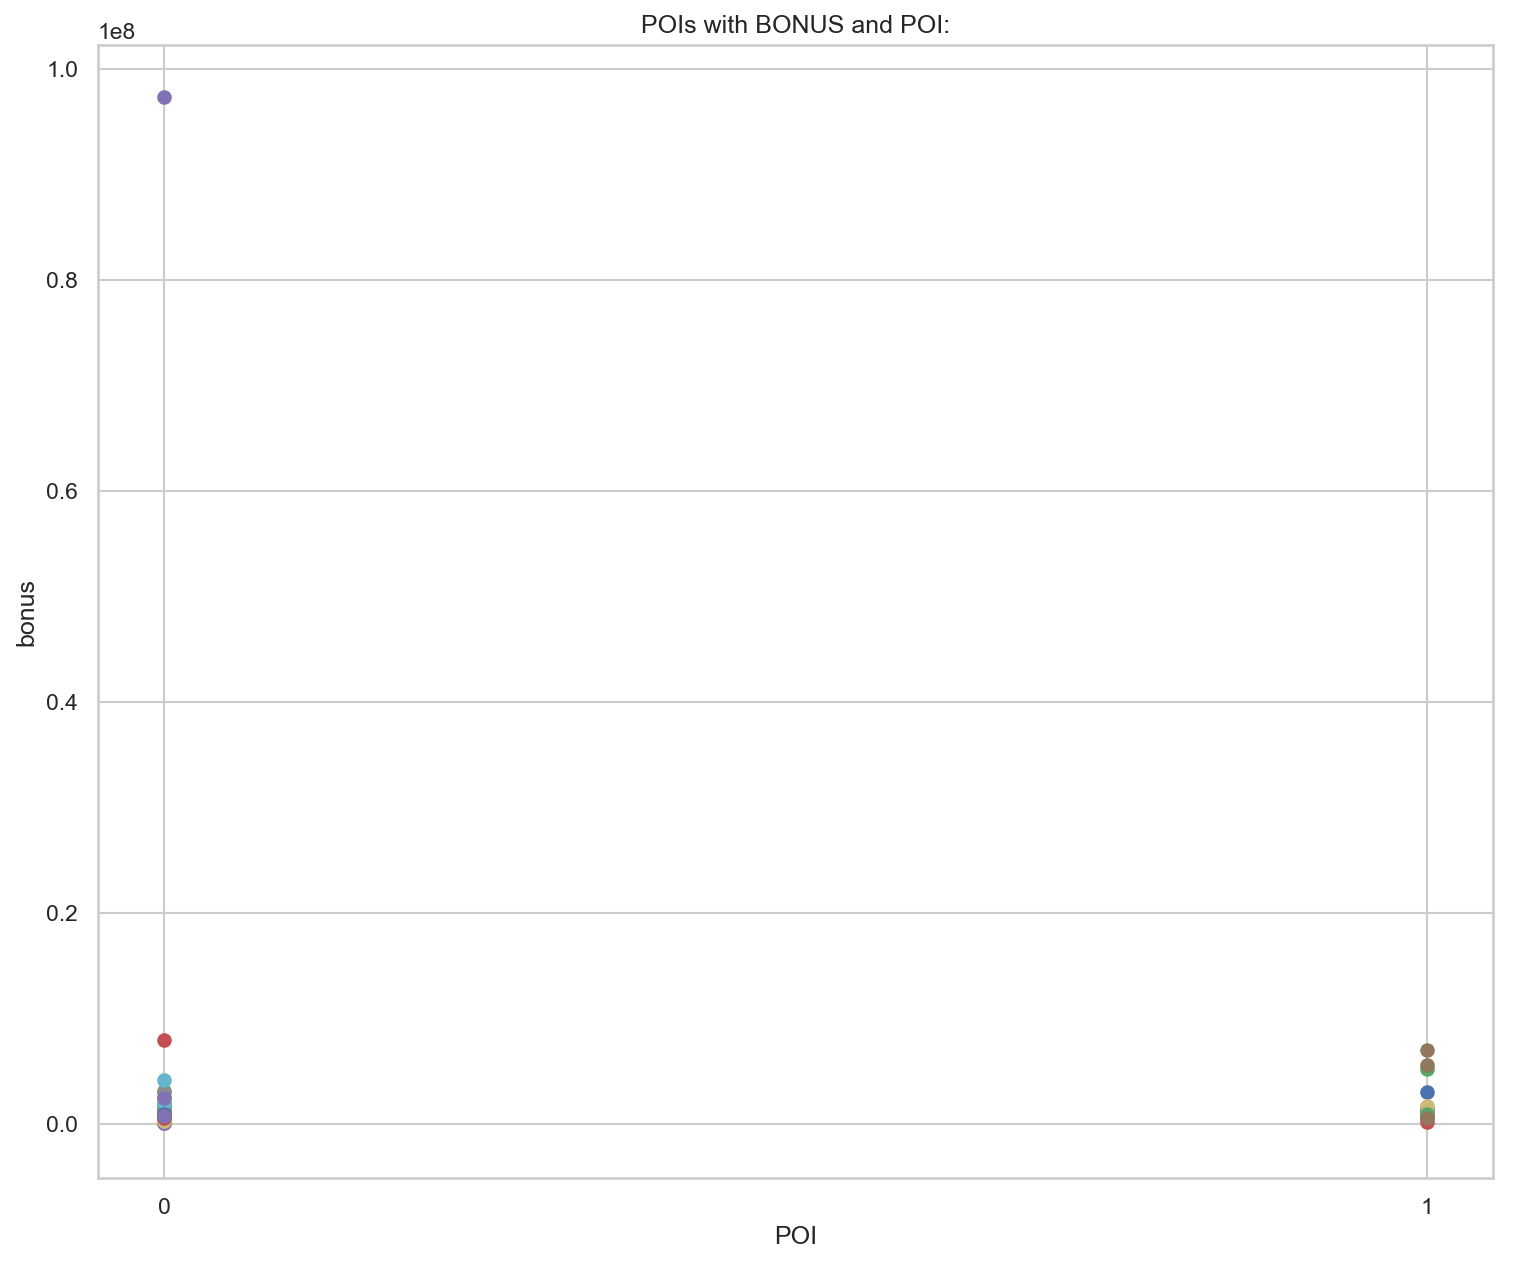

<Figure size 1800x1500 with 0 Axes>

In [45]:
plotData(df.to_dict(orient='index'), features=["poi", features_list[1]], xLabel="POI", yLabel=features_list[1])

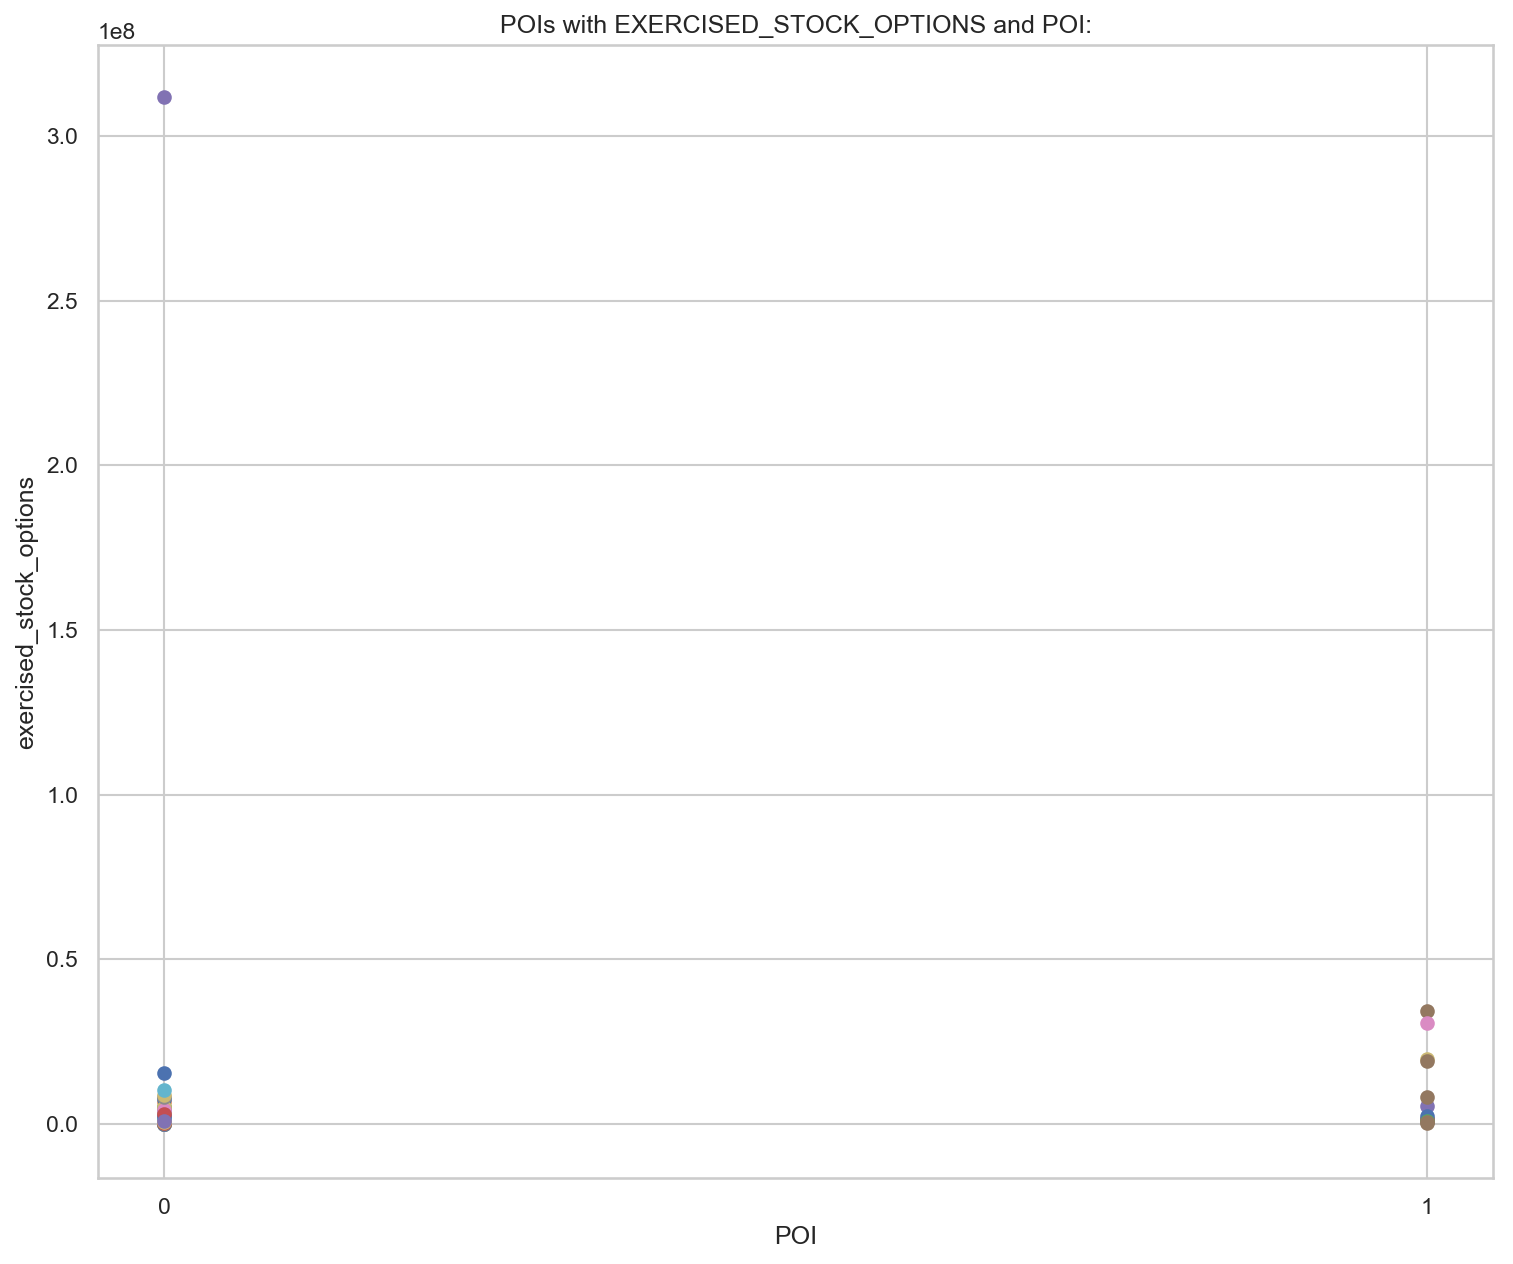

<Figure size 1800x1500 with 0 Axes>

In [46]:
plotData(df.to_dict(orient='index'), features=["poi", features_list[2]], xLabel="POI", yLabel=features_list[2])

# Task 3: Create Features

In [47]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "shared_receipt_with_poi",
    "total_payments",
    "restricted_stock",
    "expenses"
] 

def create_features(df, features_list):
    my_dataset = df[features_list].transpose().to_dict()
    
    data = featureFormat(my_dataset, features_list, sort_keys=True, remove_NaN=True)
    labels, features = targetFeatureSplit(data)
    labels, features = np.array(labels), np.array(features)
    
    # save 30% of data for testing
    features_train, features_test, labels_train, labels_test = train_test_split(
        features, labels, test_size=0.3, random_state=1
    )
    
    return features_train, features_test, labels_train, labels_test, features, labels, my_dataset

In [58]:
df = df.fillna(0)

def calculate_poi_msgs(x):
    total_msgs = x["from_messages"] + x["to_messages"]
    x["poi_messages"] = 0
    
    if total_msgs > 0:
        x["poi_messages"] = ((x["from_poi_to_this_person"] + x["from_this_person_to_poi"]) / float(total_msgs)) * 100

    return x["poi_messages"]

df["poi_messages"] = df.apply(calculate_poi_msgs, axis=1)

# display(df[features_list + ["poi_messages"]].head())

summarizeFeature(df, "poi_messages")
### Store to my_dataset for easy export below.
# my_dataset = data_dict
# my_dataset = df[features_list + ["poi_messages"]].transpose().to_dict()

# features_list = features_list + ["poi_messages"]

features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "shared_receipt_with_poi",
    "total_payments",
    "restricted_stock",
    "expenses",
    "poi_messages"
] 

features_train, features_test, labels_train, labels_test, features, labels, _ = create_features(df, features_list)

# feature_1, feature_2 = features_list[1:3]
poi = 'poi'


SUMMARY FOR: 'POI_MESSAGES'
count   146.00
mean      2.81
std       4.27
min       0.00
25%       0.00
50%       0.79
75%       4.25
max      22.44
Name: poi_messages, dtype: float64



# Task 4: Try a variety of classifiers

In [49]:
def printPredictions(predictions, labels_test):
    print
    print("{} predictions / {} test data points".format(len(predictions), len(labels_test)))
    display("PREDICTIONS: ", pd.DataFrame(predictions, dtype=int).transpose())
    display("TEST: ", pd.DataFrame(labels_test, dtype=int).transpose())
    print "{} POIs detected".format(len([n for n in predictions if n == 1]))
    print
    

In [50]:
# def printValidationReports(labels_test, pred, clf_name, clf, features, labels):
#     print "{} Accuracy: {:.2f}%".format(clf_name, search.score(features_test, labels_test) * 100)
#     print "Mean 10-Fold Cross Validation Test Score: {:.2f}%".format(cross_validate(clf, features, labels, cv=10, scoring='accuracy')["test_score"].mean() * 100)

#     # Build a text report showing the main classification metrics.
#     print classification_report(y_true=labels_test, y_pred=pred, target_names=['NOT POI', 'POI'])

#     # Compute confusion matrix to evaluate the accuracy of a classification.
#     print confusion_matrix(y_true=labels_test, y_pred=pred)

## GaussianNB (PCA)
```
GaussianNB Accuracy: 95.00%
Mean 10-Fold Cross Validation Test Score: 85.92%
              precision    recall  f1-score   support

     NOT POI       1.00      0.95      0.97        37
         POI       0.60      1.00      0.75         3

   micro avg       0.95      0.95      0.95        40
   macro avg       0.80      0.97      0.86        40
weighted avg       0.97      0.95      0.96        40

[[35  2]
 [ 0  3]]
```

'GridSearch Best Estimator'

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GaussianNB(priors=None, var_smoothing=1e-09))])


GaussianNB Accuracy: 95.00%
Mean 10-Fold Cross Validation Test Score: 85.92%
              precision    recall  f1-score   support

     NOT POI       1.00      0.95      0.97        37
         POI       0.60      1.00      0.75         3

   micro avg       0.95      0.95      0.95        40
   macro avg       0.80      0.97      0.86        40
weighted avg       0.97      0.95      0.96        40

[[35  2]
 [ 0  3]]


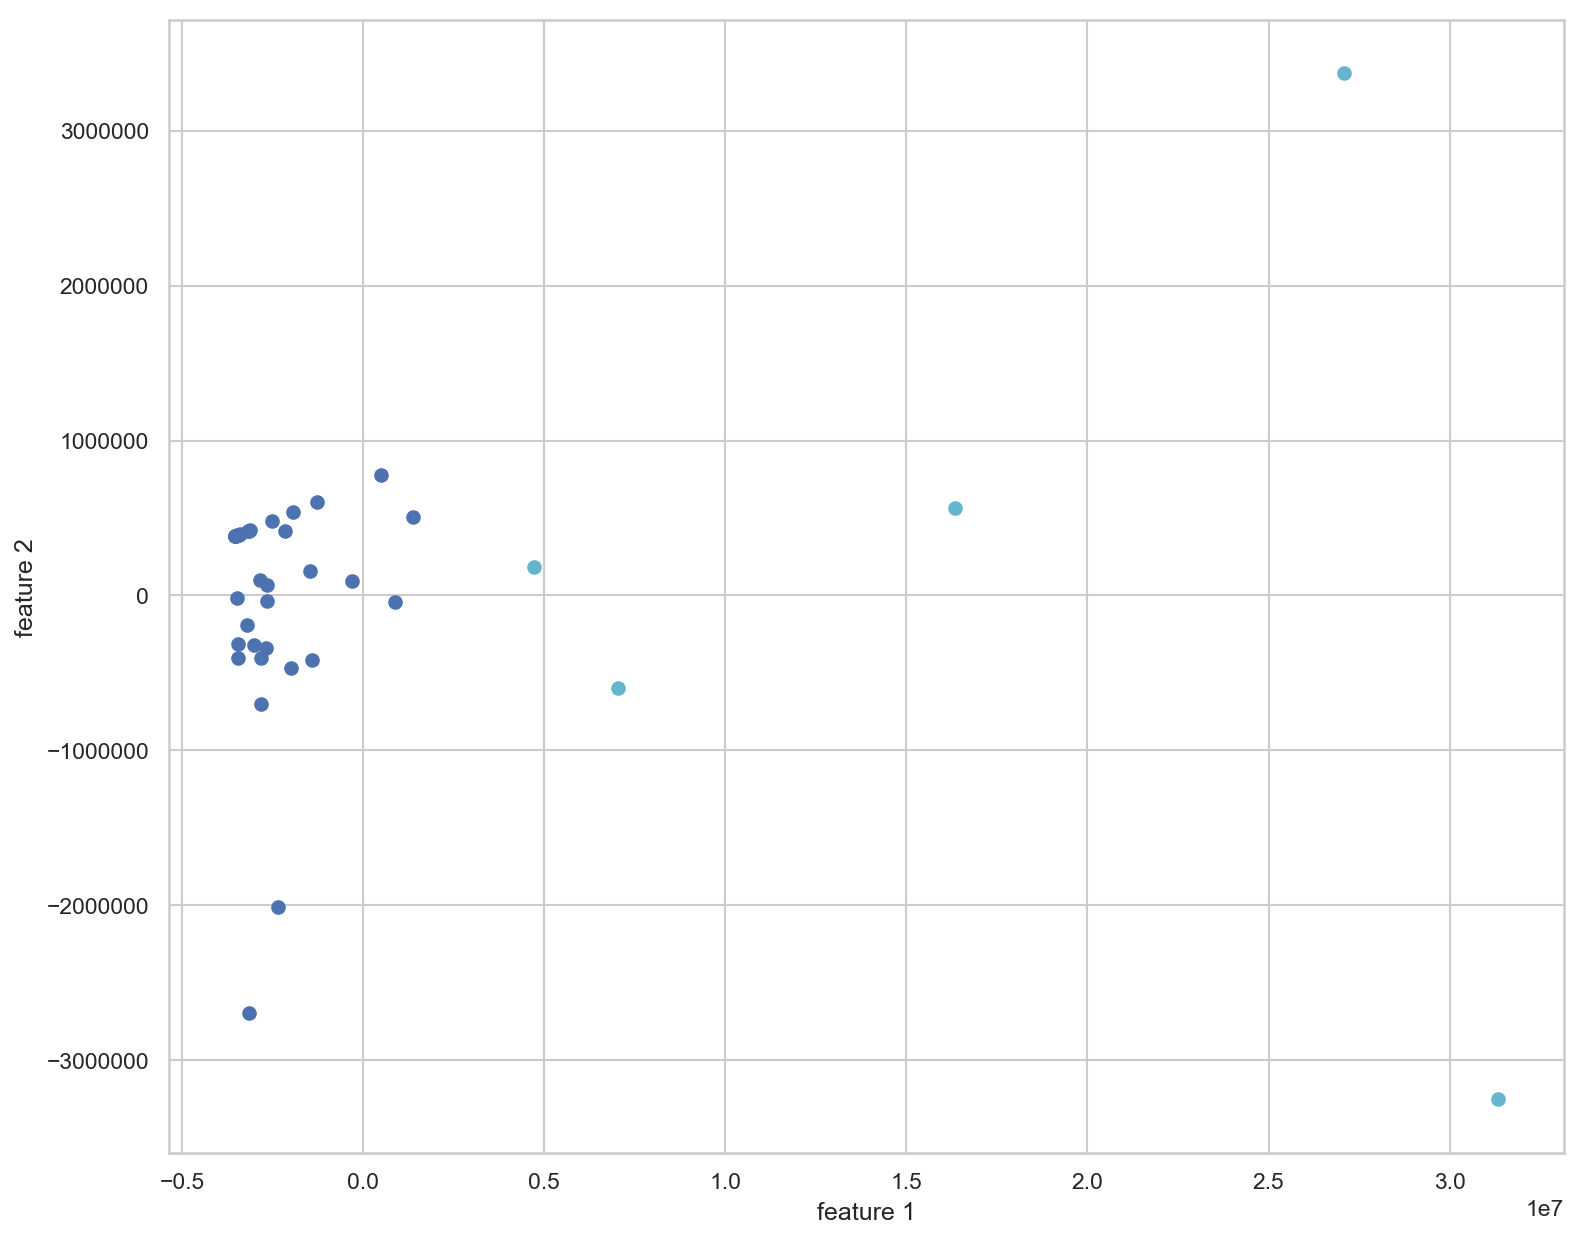

In [130]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels, _ = create_features(df, features_list)

pca = PCA()
pipe = Pipeline(steps=[("pca", pca), ("clf", GaussianNB())])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "GaussianNB", search, features, labels)
# printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)

## GaussianNB (StandardScaler + PCA)
```
GaussianNB Accuracy: 97.50%
Mean 10-Fold Cross Validation Test Score: 85.76%
              precision    recall  f1-score   support

     NOT POI       1.00      0.97      0.99        37
         POI       0.75      1.00      0.86         3

   micro avg       0.97      0.97      0.97        40
   macro avg       0.88      0.99      0.92        40
weighted avg       0.98      0.97      0.98        40

[[36  1]
 [ 0  3]]
```

'GridSearch Best Estimator'

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GaussianNB(priors=None, var_smoothing=1e-09))])


GaussianNB Accuracy: 97.50%
Mean 10-Fold Cross Validation Test Score: 85.76%
              precision    recall  f1-score   support

     NOT POI       1.00      0.97      0.99        37
         POI       0.75      1.00      0.86         3

   micro avg       0.97      0.97      0.97        40
   macro avg       0.88      0.99      0.92        40
weighted avg       0.98      0.97      0.98        40

[[36  1]
 [ 0  3]]


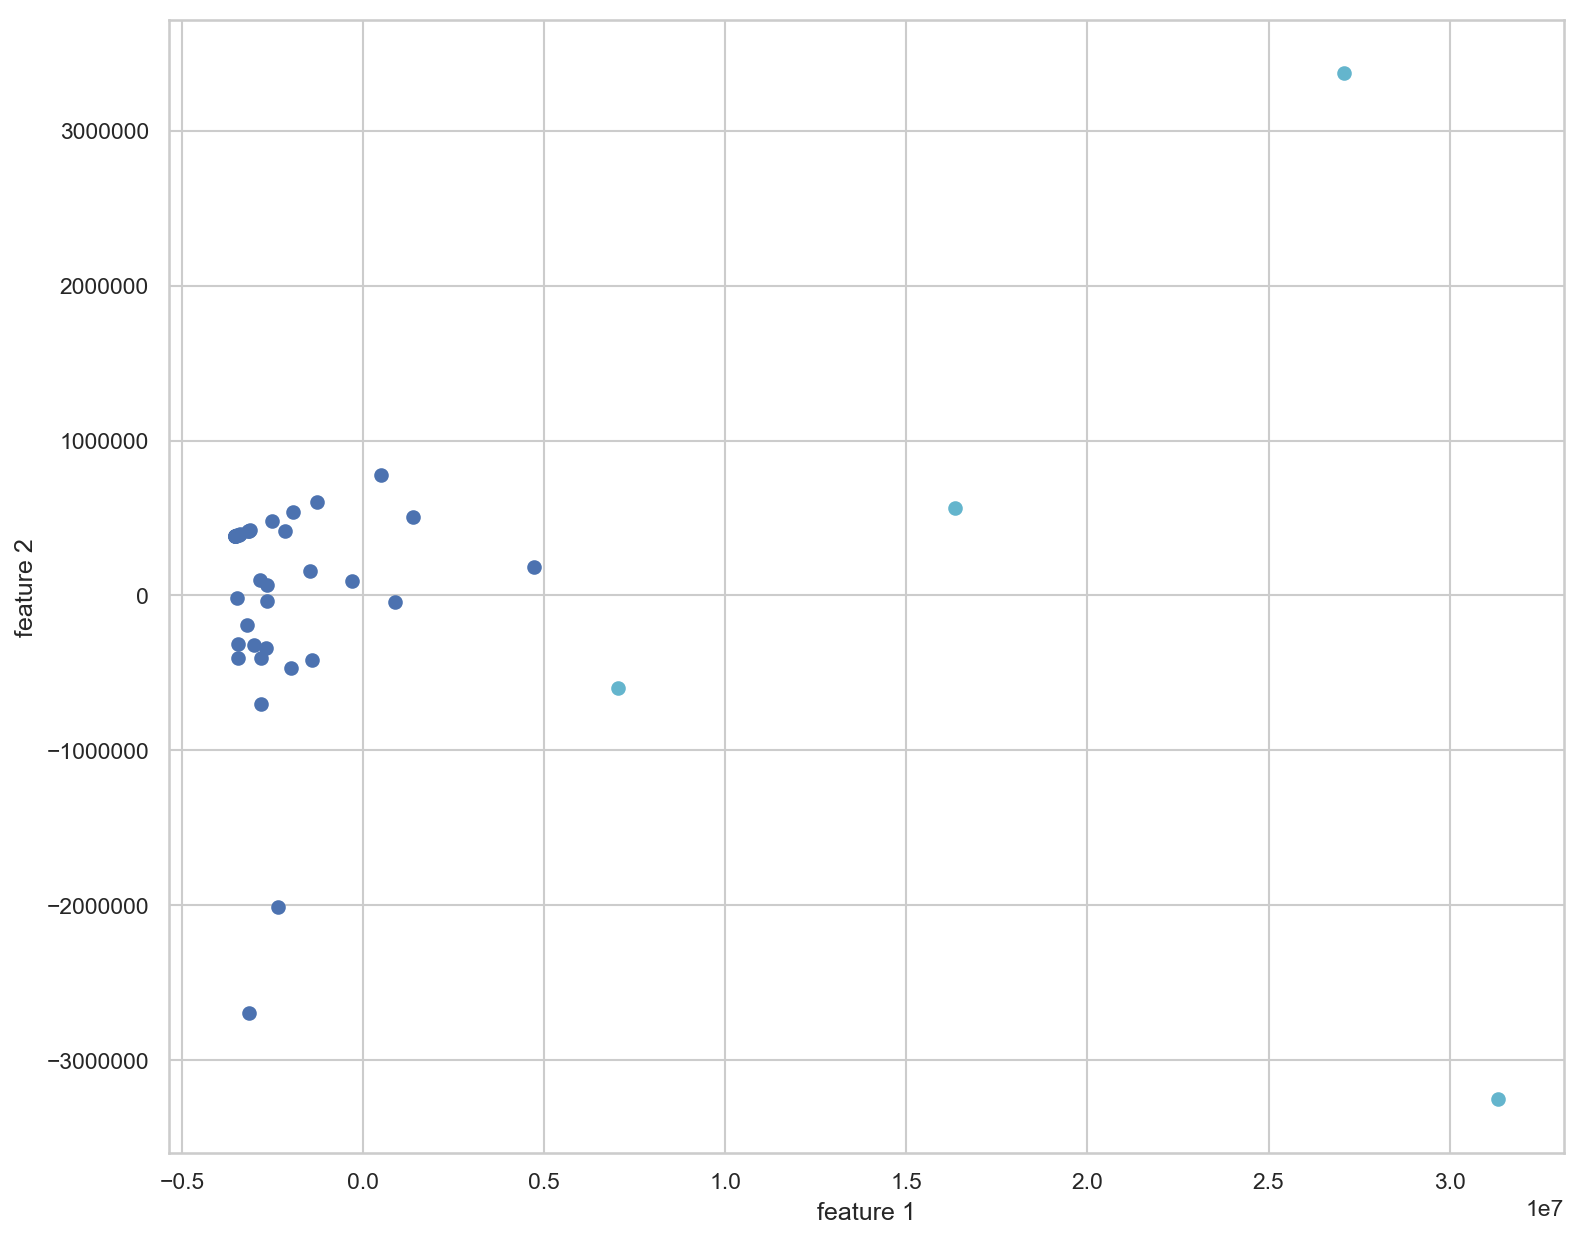

In [131]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels, _ = create_features(df, features_list)

pca = PCA()
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("pca", pca), ("clf", GaussianNB())])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "GaussianNB", search, features, labels)
# printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)

## GaussianNB (MinMaxScaler + PCA)
```
GaussianNB Accuracy: 92.50%
Mean 10-Fold Cross Validation Test Score: 84.93%
              precision    recall  f1-score   support

     NOT POI       0.93      1.00      0.96        37
         POI       0.00      0.00      0.00         3

   micro avg       0.93      0.93      0.93        40
   macro avg       0.46      0.50      0.48        40
weighted avg       0.86      0.93      0.89        40

[[37  0]
 [ 3  0]]
```

In [ ]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels, _ = create_features(df, features_list)
pca = PCA()
pipe = Pipeline(steps=[("scaler", MinMaxScaler()), ("pca", pca), ("clf", GaussianNB())])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "GaussianNB", search, features, labels)
# printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
)

# DecisionTreeClassifier (PCA)
```
DecisionTreeClassifier Accuracy: 90.00%
Mean 10-Fold Cross Validation Test Score: 85.57%
              precision    recall  f1-score   support

     NOT POI       0.92      0.97      0.95        37
         POI       0.00      0.00      0.00         3

   micro avg       0.90      0.90      0.90        40
   macro avg       0.46      0.49      0.47        40
weighted avg       0.85      0.90      0.88        40

[[36  1]
 [ 3  0]]
```

In [ ]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels, _ = create_features(df, features_list)
pca = PCA()
pipe = Pipeline(steps=[("pca", pca), ("clf", DecisionTreeClassifier(random_state=1))])

param_grid = {
#     "pca__n_components": range(1, len(features_list) -1),
    "clf__criterion": ["gini", "entropy"],
    "clf__splitter": ["best", "random"],
    "clf__min_samples_split": [2, 4, 6, 8, 10, 20, 30, 40]       
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "DecisionTreeClassifier", search, features, labels)
printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)


# DecisionTreeClassifier (StandardScaler + PCA)
```
DecisionTreeClassifier Accuracy: 95.00%
Mean 10-Fold Cross Validation Test Score: 85.86%
              precision    recall  f1-score   support

     NOT POI       0.97      0.97      0.97        37
         POI       0.67      0.67      0.67         3

   micro avg       0.95      0.95      0.95        40
   macro avg       0.82      0.82      0.82        40
weighted avg       0.95      0.95      0.95        40

[[36  1]
 [ 1  2]]
```

In [1]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels, _ = create_features(df, features_list)
pca = PCA()
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("pca", pca), ("clf", DecisionTreeClassifier(random_state=1))])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
    "clf__criterion": ["gini", "entropy"],
    "clf__splitter": ["best", "random"],
    "clf__min_samples_split": [2, 4, 6, 8, 10, 20, 30, 40]       
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "DecisionTreeClassifier", search, features, labels)
printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
)


NameError: name 'create_features' is not defined

# DecisionTreeClassifier (MinMaxScaler + PCA)
```
DecisionTreeClassifier Accuracy: 100.00%
Mean 10-Fold Cross Validation Test Score: 84.99%
              precision    recall  f1-score   support

     NOT POI       1.00      1.00      1.00        37
         POI       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

[[37  0]
 [ 0  3]]
```

'GridSearch Best Estimator'

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_feat...       min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='random'))])


DecisionTreeClassifier Accuracy: 100.00%
Mean 10-Fold Cross Validation Test Score: 84.99%
              precision    recall  f1-score   support

     NOT POI       1.00      1.00      1.00        37
         POI       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

[[37  0]
 [ 0  3]]

40 predictions / 40 test data points
PREDICTIONS:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
TEST:     0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  \
0   0   0   0   0   0   0   0   0   0   1   0   0   0   1   1   0   0   0   0   

   38  39  
0   0   0  
3 P

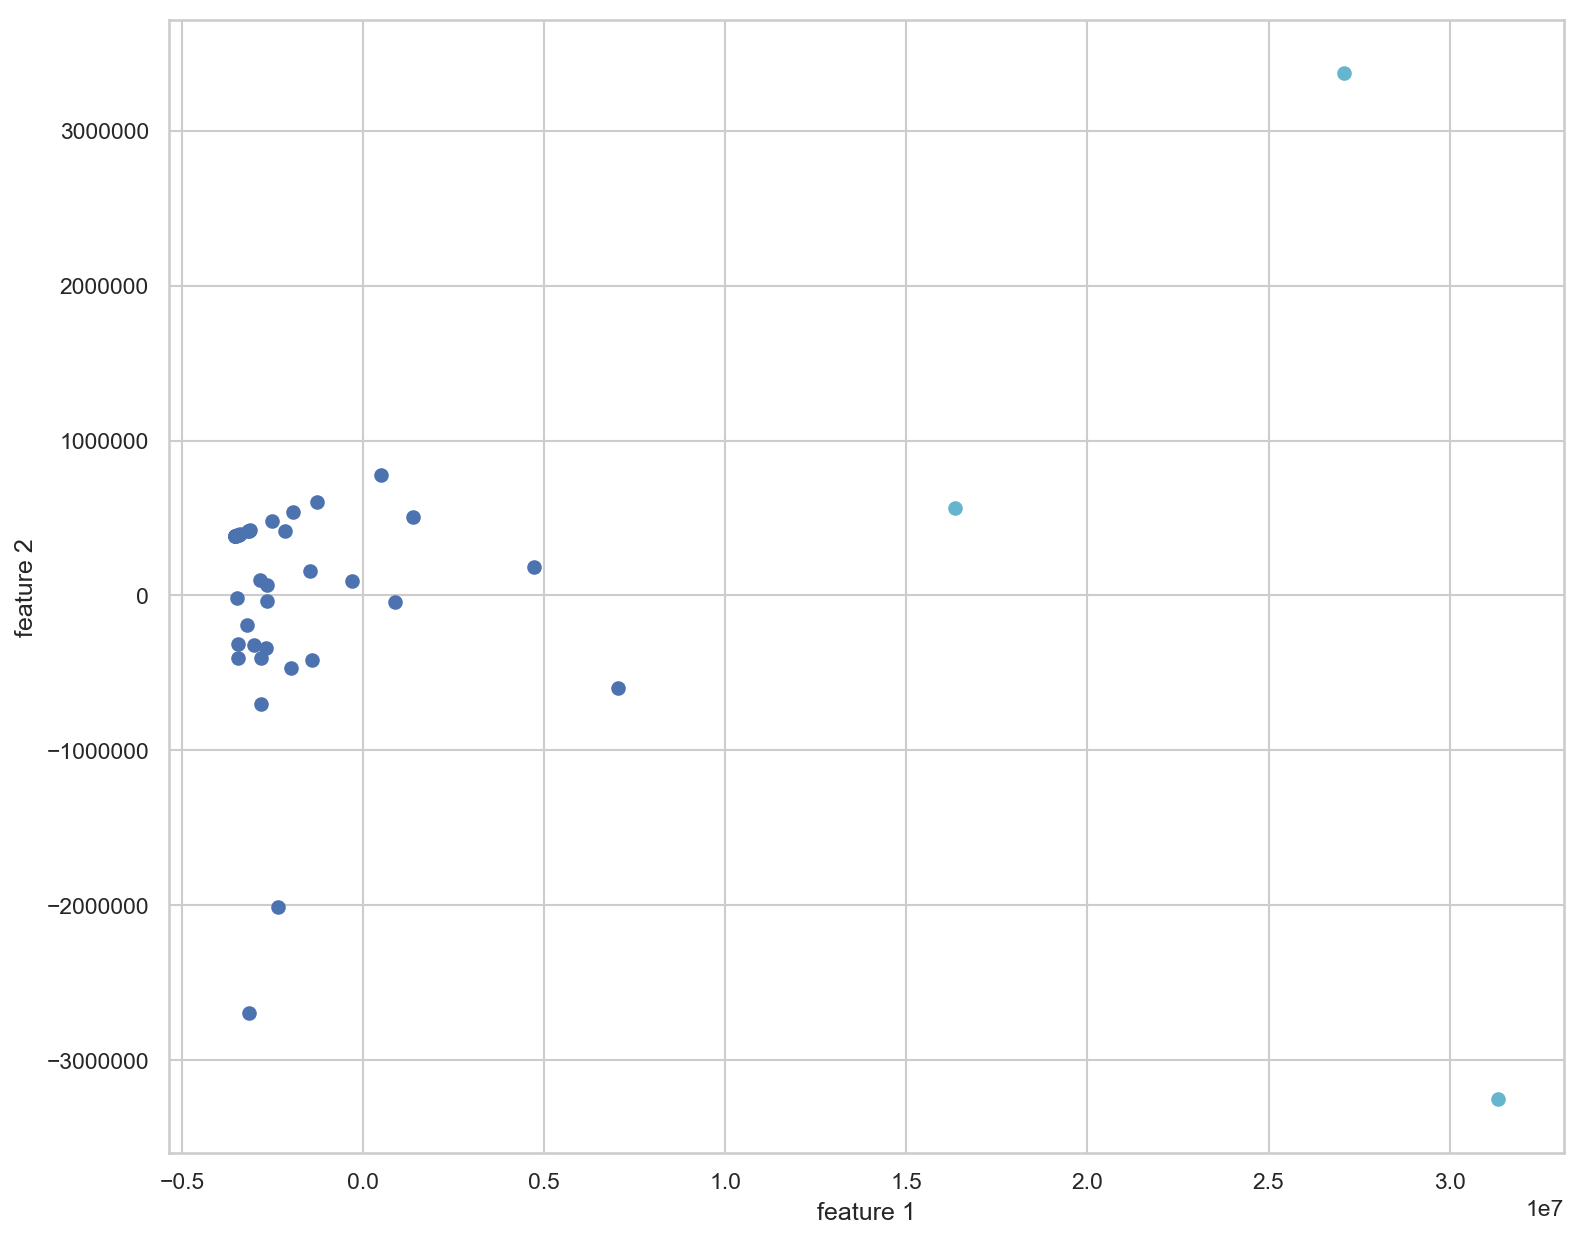

In [133]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 


features_train, features_test, labels_train, labels_test, features, labels, _ = create_features(df, features_list)
pca = PCA()
pipe = Pipeline(steps=[("scaler", MinMaxScaler()), ("pca", pca), ("clf", DecisionTreeClassifier(random_state=1))])

param_grid = {
#     "pca__n_components": range(1, len(features_list) -1),
    "clf__criterion": ["gini", "entropy"],
    "clf__splitter": ["best", "random"],
    "clf__min_samples_split": [2, 4, 6, 8, 10, 20, 30, 40]       
}

search = GridSearchCV(pipe, param_grid, iid=True)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "DecisionTreeClassifier", search, features, labels)
printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)


# AdaBoost (PCA)
```
AdaBoostClassifier Accuracy: 87.50%
Mean 10-Fold Cross Validation Test Score: 87.30%
              precision    recall  f1-score   support

     NOT POI       0.94      0.92      0.93        37
         POI       0.25      0.33      0.29         3

   micro avg       0.88      0.88      0.88        40
   macro avg       0.60      0.63      0.61        40
weighted avg       0.89      0.88      0.88        40

[[34  3]
 [ 2  1]]
```

In [ ]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels = create_features(df, features_list)
 
pipe = Pipeline(steps=[("pca", PCA()), ("clf", AdaBoostClassifier(random_state=0))])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
    "clf__n_estimators": [25, 50, 75, 100],
    "clf__algorithm": ['SAMME', "SAMME.R"]    
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "AdaBoostClassifier", search, features, labels)
printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)


# AdaBoost (StandardScaler + PCA)
```
AdaBoostClassifier Accuracy: 97.50%
Mean 10-Fold Cross Validation Test Score: 86.58%
              precision    recall  f1-score   support

     NOT POI       0.97      1.00      0.99        37
         POI       1.00      0.67      0.80         3

   micro avg       0.97      0.97      0.97        40
   macro avg       0.99      0.83      0.89        40
weighted avg       0.98      0.97      0.97        40

[[37  0]
 [ 1  2]]
```

In [ ]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels = create_features(df, features_list)
 
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("pca", PCA()), ("clf", AdaBoostClassifier(random_state=0))])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
    "clf__n_estimators": [25, 50, 75, 100],
    "clf__algorithm": ['SAMME', "SAMME.R"]    
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "AdaBoostClassifier", search, features, labels)
# printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)


# AdaBoost (MinMaxScaler + PCA)
```
AdaBoostClassifier Accuracy: 87.50%
Mean 10-Fold Cross Validation Test Score: 85.87%
              precision    recall  f1-score   support

     NOT POI       0.94      0.92      0.93        37
         POI       0.25      0.33      0.29         3

   micro avg       0.88      0.88      0.88        40
   macro avg       0.60      0.63      0.61        40
weighted avg       0.89      0.88      0.88        40

[[34  3]
 [ 2  1]]
```

In [ ]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels = create_features(df, features_list)
 
pipe = Pipeline(steps=[("scaler", MinMaxScaler()), ("pca", PCA()), ("clf", AdaBoostClassifier(random_state=0))])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
    "clf__n_estimators": [25, 50, 75, 100],
    "clf__algorithm": ['SAMME', "SAMME.R"]    
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "AdaBoostClassifier", search, features, labels)
# printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)


# RandomForest (PCA)
```
AdaBoostClassifier Accuracy: 87.50%
Mean 10-Fold Cross Validation Test Score: 85.87%
              precision    recall  f1-score   support

     NOT POI       0.94      0.92      0.93        37
         POI       0.25      0.33      0.29         3

   micro avg       0.88      0.88      0.88        40
   macro avg       0.60      0.63      0.61        40
weighted avg       0.89      0.88      0.88        40

[[34  3]
 [ 2  1]]
```

In [ ]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels = create_features(df, features_list)
 
pipe = Pipeline(steps=[("pca", PCA()), ("clf", RandomForestClassifier(random_state=0))])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
    "clf__criterion": ["gini", "entropy"],
    "clf__n_estimators": [5, 10, 25, 50, 75, 100],
    "clf__max_depth": [2, 4, 6, 8, 10, 20],
    "clf__min_samples_split": [2, 6, 10, 20, 30],
    "clf__class_weight": ["balanced", "balanced_subsample"] 
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "RandomForestClassifier", search, features, labels)
# printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)


# RandomForest (StandardScaler + PCA)
```
AdaBoostClassifier Accuracy: 87.50%
Mean 10-Fold Cross Validation Test Score: 85.87%
              precision    recall  f1-score   support

     NOT POI       0.94      0.92      0.93        37
         POI       0.25      0.33      0.29         3

   micro avg       0.88      0.88      0.88        40
   macro avg       0.60      0.63      0.61        40
weighted avg       0.89      0.88      0.88        40

[[34  3]
 [ 2  1]]
```

In [ ]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels = create_features(df, features_list)
 
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("pca", PCA()), ("clf", RandomForestClassifier(random_state=0))])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
    "clf__criterion": ["gini", "entropy"],
    "clf__n_estimators": [5, 10, 25, 50, 75, 100],
    "clf__max_depth": [2, 4, 6, 8, 10, 20],
    "clf__min_samples_split": [2, 6, 10, 20, 30],
    "clf__class_weight": ["balanced", "balanced_subsample"] 
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "RandomForestClassifier", search, features, labels)
# printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)


# RandomForest (MinMaxScaler + PCA)
```
AdaBoostClassifier Accuracy: 87.50%
Mean 10-Fold Cross Validation Test Score: 85.87%
              precision    recall  f1-score   support

     NOT POI       0.94      0.92      0.93        37
         POI       0.25      0.33      0.29         3

   micro avg       0.88      0.88      0.88        40
   macro avg       0.60      0.63      0.61        40
weighted avg       0.89      0.88      0.88        40

[[34  3]
 [ 2  1]]
```

In [ ]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels = create_features(df, features_list)
 
pipe = Pipeline(steps=[("scaler", MinMaxScaler()), ("pca", PCA()), ("clf", RandomForestClassifier(random_state=1))])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
    "clf__criterion": ["gini", "entropy"],
    "clf__n_estimators": [5, 10, 25],
    "clf__max_depth": [2, 4, 10, 20],
    "clf__min_samples_split": [2, 10, 20],
    "clf__class_weight": ["balanced", "balanced_subsample"]
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "RandomForestClassifier", search, features, labels)
# printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)


# KNN (PCA)
```
KNeighborsClassifier Accuracy: 92.50%
Mean 10-Fold Cross Validation Test Score: 84.74%
              precision    recall  f1-score   support

     NOT POI       0.93      1.00      0.96        37
         POI       0.00      0.00      0.00         3

   micro avg       0.93      0.93      0.93        40
   macro avg       0.46      0.50      0.48        40
weighted avg       0.86      0.93      0.89        40

[[37  0]
 [ 3  0]]
```

In [ ]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels = create_features(df, features_list)
pca = PCA()
pipe = Pipeline(steps=[("pca", pca), ("clf", KNeighborsClassifier())])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
    "clf__n_neighbors": [2, 4, 6, 8],
    "clf__weights": ['uniform', 'distance'],
    "clf__algorithm": ['ball_tree', 'kd_tree', 'brute',],
    "clf__leaf_size": [5, 10],
    "clf__p": [1, 2]
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "KNeighborsClassifier", search, features, labels)
# printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)


# KNN (StandardScaler + PCA)
```
KNeighborsClassifier Accuracy: 92.50%
Mean 10-Fold Cross Validation Test Score: 87.34%
              precision    recall  f1-score   support

     NOT POI       0.93      1.00      0.96        37
         POI       0.00      0.00      0.00         3

   micro avg       0.93      0.93      0.93        40
   macro avg       0.46      0.50      0.48        40
weighted avg       0.86      0.93      0.89        40

[[37  0]
 [ 3  0]]
```

In [ ]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels = create_features(df, features_list)
 
pca = PCA()
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("pca", pca), ("clf", KNeighborsClassifier())])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
    "clf__n_neighbors": [2, 4, 6, 8],
    "clf__weights": ['uniform', 'distance'],
    "clf__algorithm": ['ball_tree', 'kd_tree', 'brute',],
    "clf__leaf_size": [5, 10],
    "clf__p": [1, 2]
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "KNeighborsClassifier", search, features, labels)
# printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)


# KNN (MinMaxScaler + PCA)
```
KNeighborsClassifier Accuracy: 82.50%
Mean 10-Fold Cross Validation Test Score: 86.63%
              precision    recall  f1-score   support

     NOT POI       0.94      0.86      0.90        37
         POI       0.17      0.33      0.22         3

   micro avg       0.82      0.82      0.82        40
   macro avg       0.55      0.60      0.56        40
weighted avg       0.88      0.82      0.85        40

[[32  5]
 [ 2  1]]
```

In [ ]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
] 

features_train, features_test, labels_train, labels_test, features, labels = create_features(df, features_list)

pca = PCA()
pipe = Pipeline(steps=[("scaler", MinMaxScaler()), ("pca", pca), ("clf", KNeighborsClassifier())])

param_grid = {
    "pca__n_components": range(1, len(features_list) -1),
    "clf__n_neighbors": [2, 4, 6, 8],
    "clf__weights": ['uniform', 'distance'],
    "clf__algorithm": ['ball_tree', 'kd_tree', 'brute',],
    "clf__leaf_size": [5, 10],
    "clf__p": [1, 2]
}

search = GridSearchCV(pipe, param_grid, iid=False)
search.fit(X=features_train, y=labels_train)
display("GridSearch Best Estimator", search.best_estimator_)
pred = search.predict(features_test)
printValidationReports(features_test, labels_test, pred, "KNeighborsClassifier", search, features, labels)
# printPredictions(pred, labels_test)

Draw(
    pred.astype(int),
    pca.fit_transform(features_test),
    poi,
    mark_poi=False,
    name="clusters.pdf",
#     f1_name=feature_1,
#     f2_name=feature_2,
)


# Task 5: Tune your classifier

# Validation

# Task 6: Display

In [ ]:
dump_classifier_and_data(clf, my_dataset, features_list)